# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [5]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 10

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [6]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

# Train and Split data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_full.numpy(), y_full.numpy(), test_size=0.3, random_state=10
)
X_train= torch.tensor(X_train, dtype=torch.float32)
y_train= torch.tensor(y_train, dtype=torch.float32)
X_val= torch.tensor(X_val, dtype=torch.float32)
y_val= torch.tensor(y_val, dtype=torch.float32)

# MLP Architecture
def init_weights(in_dim, out_dim):
    w= torch.randn(in_dim, out_dim) * 0.1
    b= torch.zeros(1, out_dim)
    w.requires_grad= True
    b.requires_grad= True
    return w,b
# Network Layers
W1,b1= init_weights(2, 16)
W2,b2= init_weights(16, 16)
W3,b3= init_weights(16, 16)
W4,b4= init_weights(16, 1)

def relu(x):
    return torch.clamp(x,min=0)
def sigmoid(x):
    return 1 / (1+ torch.exp(-x))

# Forward Pass
def forward(X):
    z1= torch.matmul(X,W1)  + b1
    a1= relu(z1)
    z2= torch.matmul(a1,W2) + b2
    a2= relu(z2)
    z3= torch.matmul(a2,W3) + b3
    a3= relu(z3)
    z4= torch.matmul(a3,W4) + b4
    return sigmoid(z4)

# Binary Cross Entropy Loss
def binary_cross_entropy(y_pred, y_true):
    eps= 1e-7
    y_pred= torch.clamp(y_pred, eps, 1 - eps)
    loss= -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss.mean()

# Accuracy
def accuracy(y_pred, y_true):
    preds= (y_pred > 0.5).float()
    return (preds == y_true).float().mean().item()

# Training Loop for SGD
epochs= 500
lr= 0.01
train_losses,val_losses= [], []
train_accs,val_accs= [], []

for epoch in range(epochs):
    # Forward Pass
    y_pred= forward(X_train)
    loss= binary_cross_entropy(y_pred, y_train)

    # Backward Pass
    loss.backward()
    # Manual SGD Update
    with torch.no_grad():
        for param in [W1, b1, W2, b2, W3, b3, W4, b4]:
            param-= lr * param.grad
            param.grad.zero_()

    # Validation
    with torch.no_grad():
        val_pred = forward(X_val)
        val_loss = binary_cross_entropy(val_pred, y_val)

    # Metrics
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(accuracy(y_pred, y_train))
    val_accs.append(accuracy(val_pred, y_val))

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Decision Boundary Map
xx, yy= np.meshgrid(np.linspace(-5, 5, 300), np.linspace(-5, 5, 300))
grid= torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    zz = forward(grid).reshape(xx.shape)

Epoch 0 | Train Loss: 0.6933 | Val Loss: 0.6932
Epoch 100 | Train Loss: 0.6837 | Val Loss: 0.6820
Epoch 200 | Train Loss: 0.6782 | Val Loss: 0.6753
Epoch 300 | Train Loss: 0.6749 | Val Loss: 0.6711
Epoch 400 | Train Loss: 0.6730 | Val Loss: 0.6684


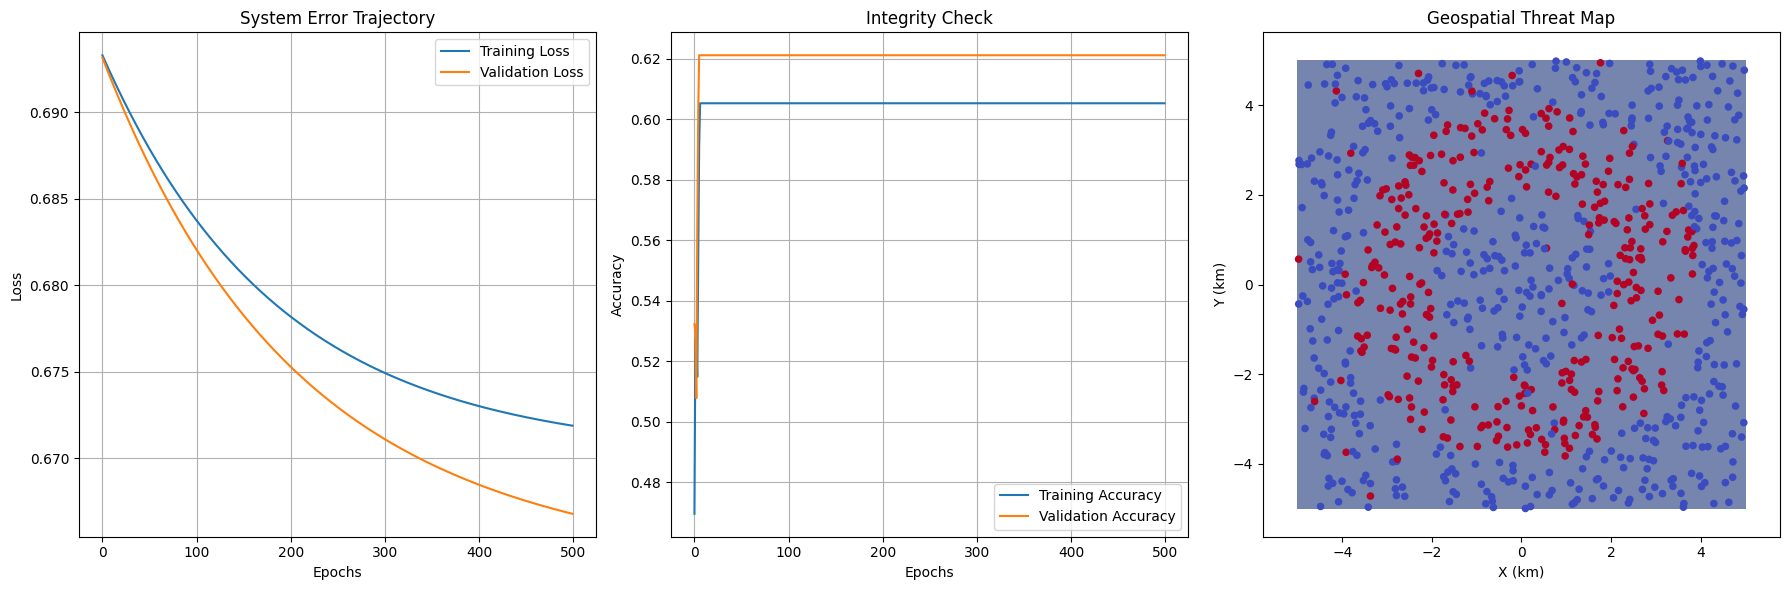

In [7]:
plt.figure(figsize=(18,6))

# Loss Trajectory Panel
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("System Error Trajectory")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Plot Panel
plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Integrity Check")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Decision Boundary Panel
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.7)
plt.contour(xx, yy, zz, levels=[0.5], colors='red')

# Plot validation points
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val[:, 0], cmap='coolwarm', s=20)
plt.title("Geospatial Threat Map")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.axis("equal")

plt.tight_layout()
plt.show()